In [1]:
import numpy as np
import matplotlib.pyplot as plt

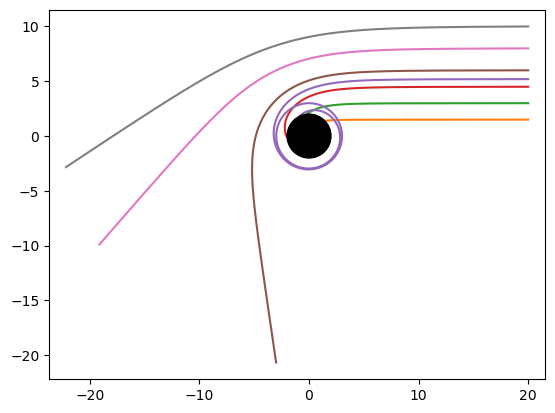

In [2]:
def euler_integrator(M, b, u_min=0.0, dphi=0.00025):
    b_2 = 1 / b**2
    u_max = 1 / (2 * M)
    u = u_min
    phi = 0.0
    us = []
    phis = []
    while u < u_max:
        us.append(u)
        phis.append(phi)
        du_dphi = (2*M*u - 1)*u**2 + b_2
        if du_dphi < 0:
            return np.array(us + us[::-1]), np.array(phis + [2*phis[-1] - phi for phi in phis[::-1]])
        u += np.sqrt(du_dphi) * dphi
        phi += dphi
    return np.array(us), np.array(phis)


M = 1.0
bs = [0.0001, 1.5, 3.0, 4.5, 3*np.sqrt(3)-1e-5, 6, 8, 10]
x_inf = 20
for b in bs:
    r_max = np.sqrt(b**2 + x_inf**2)
    us, phis = euler_integrator(M, b, 1 / r_max)
    xs = np.cos(phis + np.arcsin(b / r_max)) / us
    ys = np.sin(phis + np.arcsin(b / r_max)) / us
    plt.plot(xs, ys)
circle = plt.Circle((0., 0.), 2*M, color='black', fill=True, zorder=3)
plt.gca().add_patch(circle)
plt.axis("equal")
plt.show()

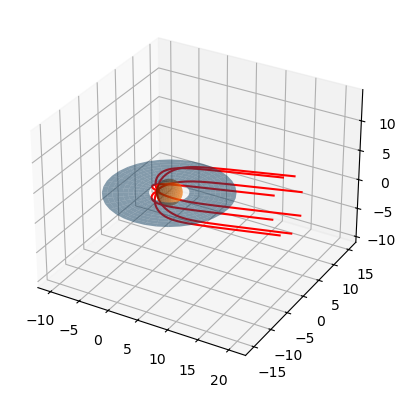

In [3]:
from mpl_toolkits.mplot3d import Axes3D

theta0 = np.deg2rad(10.0)
b = 4.5
x_inf = 20
M = 1.0
r_max = np.sqrt(b**2 + x_inf**2)
us, phis = euler_integrator(M, b, 1 / r_max)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Disk
r, beta = np.mgrid[3.0*M:10.0*M:10j, 0.0:2*np.pi:37j]
ax.plot_surface(r * np.cos(beta), r * np.sin(beta), r * beta * 0, alpha=0.5)

# BH
theta, beta = np.mgrid[0.0:np.pi:19j, 0.0:2*np.pi:37j]
ax.plot_surface(2*M * np.cos(beta) * np.sin(theta), 2*M * np.sin(beta) * np.sin(theta), 
                2*M * (1 + beta*0) * np.cos(theta), alpha=0.5)

alphas = np.deg2rad(np.arange(0, 360, 45))
for alpha in alphas:
    x1s = np.cos(phis + np.arcsin(b / r_max)) / us
    y1s = np.sin(phis + np.arcsin(b / r_max)) * np.sin(alpha) / us
    z1s = np.sin(phis + np.arcsin(b / r_max)) * np.cos(alpha) / us
    x2s = x1s * np.cos(theta0) - z1s * np.sin(theta0)
    y2s = y1s
    z2s = x1s * np.sin(theta0) + z1s * np.cos(theta0)
    ax.plot3D(x2s, y2s, z2s, 'red')

ax.axis("equal")
plt.show()



(-24.0, 24.0, -18.0, 18.0)

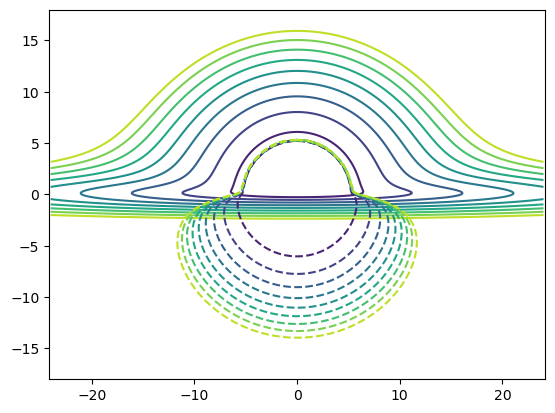

In [4]:
theta0 = np.deg2rad(87.0)
bs = np.linspace(1e-5, 40, 401)
alphas = np.linspace(0, 2*np.pi, 61)

# Integrate various orbits for different values of b
rss = []
phiss = []
for b in bs:
    us, phis = euler_integrator(M, b, 1e-5)
    rss.append(1 / us)
    phiss.append(phis)

xs, ys = np.mgrid[-18.0:18.0:361j, -24.0:24.0:481j]
r1s = np.zeros_like(xs)
r2s = np.zeros_like(xs)
js = np.arange(len(bs))
for ix, x in enumerate(xs[:,0]):
    for iy, y in enumerate(ys[0,:]):
        b = np.sqrt(x*x + y*y)
        j = np.interp(b, bs, js)
        f = j - int(j)
        alpha = np.arctan2(y, x)
        # 1st order image
        gamma1 = np.arccos(np.cos(alpha) / np.sqrt(np.cos(alpha)**2 + 1.0 / (np.tan(theta0)**2)))
        if int(j) == 0:
            r_a = 0.0
        else:
            r_a = np.interp(gamma1, phiss[int(j)], rss[int(j)])
        r_b = np.interp(gamma1, phiss[int(j) + 1], rss[int(j) + 1])
        r1s[ix, iy] = np.minimum(r_a * (1 - f) + r_b * f, 50)
        # Same for the 2nd order image
        gamma2 = gamma1 + np.pi
        if int(j) == 0:
            r_a = 0.0
        else:
            r_a = np.interp(gamma2, phiss[int(j)], rss[int(j)])
        r_b = np.interp(gamma2, phiss[int(j) + 1], rss[int(j) + 1])
        r2s[ix, iy] = np.minimum(r_a * (1 - f) + r_b * f, 50)

plt.contour(ys, -xs, r1s, levels=10);
plt.contour(ys, -xs, r2s, levels=10, linestyles="dashed");
plt.axis("equal")

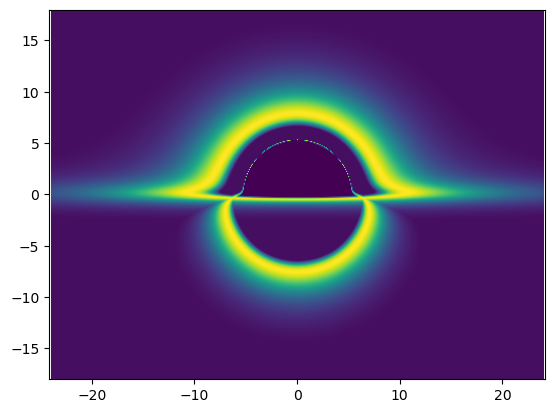

In [5]:
rM = np.maximum(r1s / M, 6)
F1 = (np.sqrt(rM) - np.sqrt(6) + np.log(((np.sqrt(rM) + np.sqrt(3)) * (np.sqrt(6) - np.sqrt(3))) /
                                        ((np.sqrt(rM) - np.sqrt(3)) * (np.sqrt(6) + np.sqrt(3))))
      * np.sqrt(3) / 2) / ((rM - 3) * rM**2.5)
rM = np.maximum(r2s / M, 6)
F2 = (np.sqrt(rM) - np.sqrt(6) + np.log(((np.sqrt(rM) + np.sqrt(3)) * (np.sqrt(6) - np.sqrt(3))) /
                                        ((np.sqrt(rM) - np.sqrt(3)) * (np.sqrt(6) + np.sqrt(3))))
      * np.sqrt(3) / 2) / ((rM - 3) * rM**2.5)
plt.imshow(np.maximum(F1, F2), extent=[-24, 24, -18, 18]);
plt.axis("equal")
plt.show()

/var/folders/_r/flgz8mc97j16zsg6px5s40d00000gn/T/ipykernel_6498/373844228.py:3: RuntimeWarning: divide by zero encountered in divide
  z1 = (1 + np.sqrt(M / r1s**3) * bs * np.sin(theta0) * np.sin(alphas)) / np.sqrt(1 - 3*M / r1s)
/var/folders/_r/flgz8mc97j16zsg6px5s40d00000gn/T/ipykernel_6498/373844228.py:3: RuntimeWarning: invalid value encountered in multiply
  z1 = (1 + np.sqrt(M / r1s**3) * bs * np.sin(theta0) * np.sin(alphas)) / np.sqrt(1 - 3*M / r1s)
/var/folders/_r/flgz8mc97j16zsg6px5s40d00000gn/T/ipykernel_6498/373844228.py:3: RuntimeWarning: invalid value encountered in sqrt
  z1 = (1 + np.sqrt(M / r1s**3) * bs * np.sin(theta0) * np.sin(alphas)) / np.sqrt(1 - 3*M / r1s)
/var/folders/_r/flgz8mc97j16zsg6px5s40d00000gn/T/ipykernel_6498/373844228.py:4: RuntimeWarning: divide by zero encountered in divide
  z2 = (1 + np.sqrt(M / r2s**3) * bs * np.sin(theta0) * np.sin(alphas)) / np.sqrt(1 - 3*M / r2s)
/var/folders/_r/flgz8mc97j16zsg6px5s40d00000gn/T/ipykernel_6498/373844228.py:4: Ru

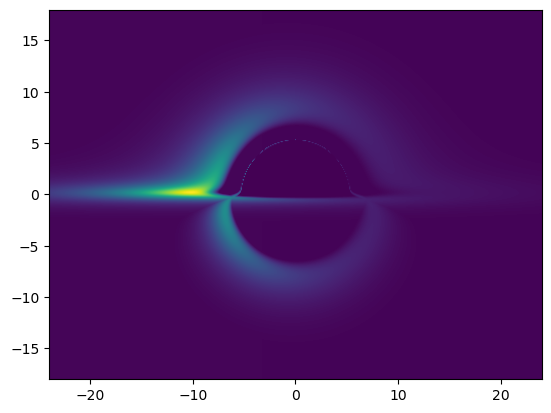

In [6]:
bs = np.sqrt(xs*xs + ys*ys)
alphas = np.arctan2(ys, xs)
z1 = (1 + np.sqrt(M / r1s**3) * bs * np.sin(theta0) * np.sin(alphas)) / np.sqrt(1 - 3*M / r1s)
z2 = (1 + np.sqrt(M / r2s**3) * bs * np.sin(theta0) * np.sin(alphas)) / np.sqrt(1 - 3*M / r2s)
z1[np.isnan(z1)] = 1
z2[np.isnan(z2)] = 1
plt.imshow(np.maximum(F1 / z1**4, F2 / z2**4), extent=[-24, 24, -18, 18]);
